In [1]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

2024-10-13 10:13:26.626413: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

In [4]:
df = pd.read_csv("./Handwritten_Signature_Dataset/file_identity.csv")

In [5]:
df.head()

,FILENAME,IDENTITY,VIETNAMESE IDENTITY
0,FILE_1.png,BUI DUONG QUOC THAI,BÙI DƯƠNG QUỐC THÁI
1,FILE_2.png,CUONG,CƯỜNG
2,FILE_3.png,DANG NGOC TRAM ANH,ĐẶNG NGỌC TRÂM ANH
3,FILE_4.png,DINH PHUONG TIN,ĐINH PHƯƠNG TÍN
4,FILE_5.png,DINH THI TUYET NHUNG,ĐINH THỊ TUYẾT NHUNG


In [ ]:
plt.figure(figsize=(8, 8))
for i in range(6):
    plt.subplot(3, 2, i+1)
    dir = "./Handwritten_Signature_Dataset/train/" + df.loc[i, "FILENAME"]
    img = cv2.imread(dir)
    plt.title(df.loc[i, "VIETNAMESE IDENTITY"])
    plt.imshow(img)
    plt.subplots_adjust(hspace=1)

In [10]:
train_dir = "./Handwritten_Signature_Dataset/train/"

In [13]:
IM_SIZE = 224
@tf.function
def resizing_rescale(image):
    image = tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0
    return image

libpng warning: iCCP: known incorrect sRGB profile


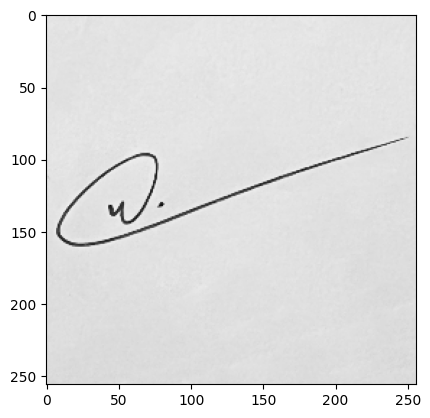

In [16]:
dir = "./Handwritten_Signature_Dataset/train/" + df.loc[1, "FILENAME"]
img = cv2.imread(dir)
img = tf.image.resize(img, (256, 256))/255.
plt.imshow(img)

In [11]:
train_dataset = []
for i in range(len(df)):
    

Found 0 files belonging to 0 classes.


ValueError: No images found in directory ./Handwritten_Signature_Dataset/train/. Allowed formats: ('.bmp', '.gif', '.jpeg', '.jpg', '.png')